# SPADE VAE-GAN

In this tutorial, we apply SPADE, a VAE-GAN-based neural network developed by Park et al. [1] that performs semantic image synthesis. We apply to a subset of BraTS [2] that we registered to MNI space and resampled to 2mm isotropic space. Segmentations of cerebrospinal fluid, grey and white matter, deep grey matter and brainstem were obtained using Geodesic Information Flows (GIF) [3].

[1] Park, T., Liu, M.-Y., Wang, T.-C., & Zhu, J.-Y. (2019). Semantic Image Synthesis with Spatially-Adaptive Normalization. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

[2] Menze, B. H., Jakab, A., Bauer, S., Kalpathy-Cramer, J., Farahani, K., Kirby, J., Burren, Y., Porz, N., Slotboom, J., Wiest, R., Lanczi, L., Gerstner, E., Weber, M.-A., Arbel, T., Avants, B. B., Ayache, N., Buendia, P., Collins, D. L., Cordier, N., … van Leemput, K. (2015). The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE Transactions on Medical Imaging, 34(10), 1993–2024. https://doi.org/10.1109/TMI.2014.2377694

[3] Cardoso, M. J., Wolz, R., Modat, M., Fox, N. C., Rueckert, D., & Ourselin, S. (2012). Geodesic information flows. Medical Image Computing and Computer-Assisted Intervention : MICCAI ...  International Conference on Medical Image Computing and Computer-Assisted Intervention, 15(Pt 2), 262–270. https://doi.org/10.1007/978-3-642-33418-4_33

## Setup environment 

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import gdown" || pip install -q gdown
%matplotlib inline

## Setup imports

In [ ]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
import zipfile
import gdown
from monai.config import print_config
from monai.utils import set_determinism
from monai.data import DataLoader
from tqdm import tqdm
import numpy as np
import monai
import torch.nn.functional as F
from monai.networks.nets import SPADENet, MultiScalePatchDiscriminator
from monai.losses import  PatchAdversarialLoss, PerceptualLoss
from torch.cuda.amp import GradScaler, autocast

print_config()

## Set-up a data directory

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = Path(root_dir)
print("Temporary directory used: %s " % root_dir)

Temporary directory used: /tmp/tmponqzk0ip 


## Set deterministic training for reproducibility

In [4]:
set_determinism(42)

## Description of data and download dataset

### Description of the data

The data for this notebook comes from the brain tumour segmentation challenge (BraTS) [2]. The images have been registered to MNI space using ANTsPy, and then subsampled to 2mm isotropic resolution. Geodesic Information Flows (GIF) [3] has been used to segment 5 regions: cerebrospinal fluid (CSF), grey matter (GM), white matter (WM), deep grey matter (DGM) and brainstem. Tumour sub-layers were delineated manually as part of the challenge source data. 
In this subset, we have only used one MRI modality , T1. 
Segmentations in this subset are merged and consist of the following labels: 0 (background), 1 (CSF), 2 (GM), 3 (WM), 4 (DGM), 5 (brainstem), 6 (brainstem), 7 (non GD-enahncing tumour core), 8 (peritumoural oedema), 9 (GD-enhancing tumour).

### Download data

In [5]:
# Comment if already downloaded!
gdown.download("https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m", os.path.join(root_dir, "data.zip"))
#!gdown -O data.zip "https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m" --remaining-ok

Downloading...
From (original): https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m
From (redirected): https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m&confirm=t&uuid=6b587214-5e85-4b78-ac3e-65dc2378cbd3
To: /tmp/tmponqzk0ip/data.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.7M/26.7M [00:00<00:00, 29.0MB/s]


'/tmp/tmponqzk0ip/data.zip'

We extract and reorganise the data into the relevant sub-folders:

In [6]:
zip_obj = zipfile.ZipFile(os.path.join(root_dir, "data.zip"), "r")
zip_obj.extractall(root_dir)
images_T1 = root_dir / "BRATS_SUBS2_SUBSET/T1"
labels = root_dir / "BRATS_SUBS2_SUBSET/Parcellations"

## Prepare dataloaders

In [7]:
# INPUT PARAMETERS
input_shape = [128, 128]
batch_size = 4
num_workers = 2
num_epochs = 100
lambda_perc = 1.0
lambda_feat = 0.1
lambda_kld = 0.00001
loss_adv = 1.0

In [8]:
# We create the data dictionaries that we need
all_images = [os.path.join(images_T1, i) for i in os.listdir(images_T1)]
np.random.shuffle(all_images)
corresponding_labels = [
    os.path.join(labels, i.split("/")[-1].replace(i.split("/")[-1].split("_")[0], "Parcellation")) for i in all_images
]
input_dict = [{"image": i, "label": corresponding_labels[ind]} for ind, i in enumerate(all_images)]
input_dict_train = input_dict[: int(len(input_dict) * 0.9)]
input_dict_val = input_dict[int(len(input_dict) * 0.9) :]

We define the relevant transforms:
1. `LoadImaged`: to load the nii tumour images and labels
2. `EnsureChannelFirstd`: to make sure that a channel dimension is added on the tensors
3. `CenterSpatialCropd`: we ensure that the image and labels have the same shape
4. `RandSpatialCropd`: because we are extracting 2D slices from 3D volumes, we crop slices
5. `SqueezeDimd`: we remove the 1-dimension of the slice
6. `Resized`: to bring the shape of all images to the same value
7. `NormalizeIntensityd`: normalise the images
8. `RandBiasFieldd`: bias field augmentation
9. `RandAdjustContrastd`: random contrast augmentation
10. `RandGaussianNoised`: random noise tradition
11. `RandAffined`: random affine augmentation

In [24]:
preliminar_shape = input_shape + [50]  # We take random slices fron the center of the brain
crop_shape = input_shape + [1]
base_transforms = [
    monai.transforms.LoadImaged(keys=["label", "image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image", "label"]),
    monai.transforms.CenterSpatialCropd(keys=["label", "image"], roi_size=preliminar_shape),
    monai.transforms.RandSpatialCropd(keys=["label", "image"], roi_size=crop_shape, max_roi_size=crop_shape),
    monai.transforms.SqueezeDimd(keys=["label", "image"], dim=-1),
    monai.transforms.Resized(keys=['label', 'image'], spatial_size = input_shape)
]
last_transforms = [
    monai.transforms.NormalizeIntensityd(keys=["image"]),
    monai.transforms.ToTensord(keys=["image", "label"]),
]

aug_transforms = [
    monai.transforms.RandBiasFieldd(coeff_range=(0, 0.005), prob=0.33, keys=["image"]),
    monai.transforms.RandAdjustContrastd(gamma=(0.9, 1.15), prob=0.33, keys=["image"]),
    monai.transforms.RandGaussianNoised(prob=0.33, mean=0.0, std=np.random.uniform(0.005, 0.015), keys=["image"]),
    monai.transforms.RandAffined(
        rotate_range=[-0.05, 0.05],
        shear_range=[0.001, 0.05],
        scale_range=[0, 0.05],
        padding_mode="zeros",
        mode="nearest",
        prob=0.33,
        keys=["label", "image"],
    ),
]

We create the dataset and dataloader:

In [25]:
train_transforms = monai.transforms.Compose(base_transforms + aug_transforms + last_transforms)
val_transforms = monai.transforms.Compose(base_transforms + last_transforms)

train_dataset = monai.data.dataset.Dataset(input_dict_train, train_transforms)
val_dataset = monai.data.dataset.Dataset(input_dict_val, val_transforms)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, shuffle=False, drop_last=False, batch_size=batch_size, num_workers=num_workers)

We do a sanity check and plot an element of the dataset:

torch.Size([4, 1, 128, 128])


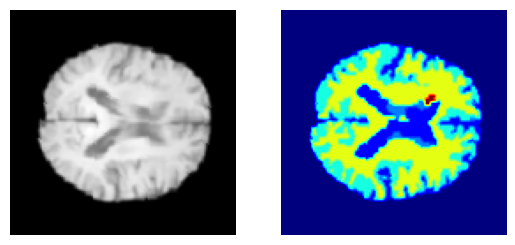

In [26]:
# Sanity check
batch = next(iter(train_loader))
print(batch["image"].shape)
plt.subplot(1, 2, 1)
plt.imshow(batch["image"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(batch["label"][0, 0, ...], cmap="jet")
plt.axis("off")
plt.show()

### Networks creation and losses

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
def one_hot(input_label, label_nc):
    # One hot encoding function for the labels
    shape_ = list(input_label.shape)
    shape_[1] = label_nc
    label_out = torch.zeros(shape_)
    for channel in range(label_nc):
        label_out[:, channel, ...] = input_label[:, 0, ...] == channel
    return label_out

In [30]:
def picture_results(input_label, input_image, output_image):
    f = plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.argmax(input_label, 1)[0, ...].detach().cpu(), cmap="jet")
    plt.axis("off")
    plt.title("Label")
    plt.subplot(1, 3, 2)
    plt.imshow(input_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Input image")
    plt.subplot(1, 3, 3)
    plt.imshow(output_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Output image")
    plt.show()

We define the KLD loss that we need to ensure that the latent space is Gaussian distributed [5].

[5] Kingma, D. P., & Welling, M. (2014). Auto-Encoding Variational Bayes. CoRR, abs/1312.6.

In [31]:
class KLDLoss(torch.nn.Module):
    """
    Computes the Kullback-Leibler divergence between a normal distribution with mean mu and variance logvar and
     one with mean 0 and variance 1.
    """

    def forward(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


The SPADE paper includes a feature loss which acts like a regulariser of the discriminator. 

In [32]:
def feature_loss(input_features_disc_fake, input_features_disc_real, lambda_feat, device):
    criterion = torch.nn.L1Loss()
    num_D = len(input_features_disc_fake)
    GAN_Feat_loss = torch.zeros(1).to(device)
    for i in range(num_D):  # for each discriminator
        num_intermediate_outputs = len(input_features_disc_fake[i])
        for j in range(num_intermediate_outputs):  # for each layer output
            unweighted_loss = criterion(input_features_disc_fake[i][j], input_features_disc_real[i][j].detach())
            GAN_Feat_loss += unweighted_loss * lambda_feat / num_D
    return GAN_Feat_loss

SPADE can be used as a GAN, for which only a decoder is necessary, or a VAE-GAN, which includes an image ("style") encoder. The decoder incorporates special normalisation blocks called "SPADE" blocks. They take the semantic map and obtain rich features to normalise the activations per semantic layer.

In [33]:
net = SPADENet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    label_nc=10,
    input_shape=input_shape,
    channels=[16, 32, 64],
    z_dim=8,
    is_vae=True,
)

SPADE is trained as a GAN network, and therefore, requires a discriminator. In Park's paper, a multi-scale patch-GAN discriminator is used.

In [34]:
discriminator = MultiScalePatchDiscriminator(
    num_d=2,
    num_layers_d=3,
    spatial_dims=2,
    channels=8,
    in_channels=11,
    out_channels=11,
    minimum_size_im=128,
    norm="INSTANCE",
    kernel_size=3,
)

adversarial_loss = PatchAdversarialLoss(reduction="sum", criterion="hinge")

Like in the paper, we also define a perceptual loss:

In [35]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="vgg", is_fake_3d=False, pretrained=True)
perceptual_loss = perceptual_loss.to(device)

In [36]:
kld_loss = KLDLoss()

In [37]:
optimizer_G = torch.optim.Adam(net.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0004)

## Training the network

We train the network on the following loss: a KLD loss to normalise the latent space, the adversarial multi-scale patch-GAN loss, the regularising feature loss and the perceptual loss. The training parameters have to be defined in the following box:

Epoch 0/100
Train: kld 452.4219; perceptual 1.7358; generator 19.3326;                    feature 0.2450; discriminator 0.8070


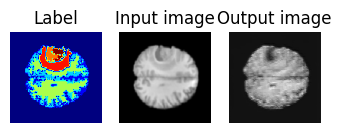

Validation: kld 58.4123; perceptual 0.2505; generator 3.2067;                feature 0.2299; discriminator 1.6941
Epoch 10/100
Train: kld 439.2858; perceptual 1.3916; generator 20.0807;                    feature 0.2375; discriminator 0.7018


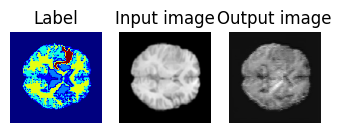

Validation: kld 56.7810; perceptual 0.2052; generator 3.2854;                feature 0.2135; discriminator 1.6120
Epoch 20/100
Train: kld 451.8312; perceptual 1.3832; generator 20.5988;                    feature 0.2438; discriminator 0.5999


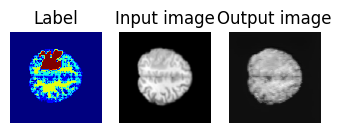

Validation: kld 68.2732; perceptual 0.2007; generator 3.4140;                feature 0.2237; discriminator 1.3955
Epoch 30/100
Train: kld 451.2612; perceptual 1.7858; generator 20.2076;                    feature 0.2397; discriminator 0.6246


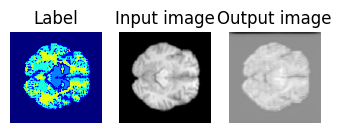

Validation: kld 68.2909; perceptual 0.3169; generator 3.4047;                feature 0.2409; discriminator 1.2504
Epoch 40/100
Train: kld 423.9260; perceptual 1.4618; generator 20.7118;                    feature 0.2177; discriminator 0.5481


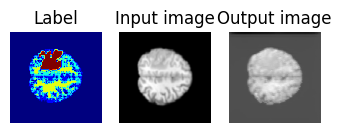

Validation: kld 62.5048; perceptual 0.2558; generator 3.4531;                feature 0.2137; discriminator 1.1059
Epoch 50/100
Train: kld 1522.1607; perceptual 1.6290; generator 19.6153;                    feature 0.2305; discriminator 0.6269


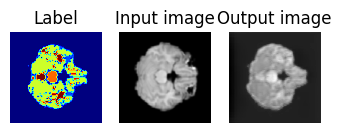

Validation: kld 244.5938; perceptual 0.3301; generator 3.3208;                feature 0.2425; discriminator 1.2383
Epoch 60/100
Train: kld 2540.0609; perceptual 1.5684; generator 20.2199;                    feature 0.2156; discriminator 0.6329


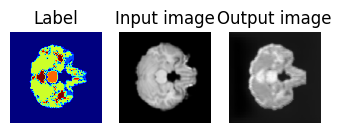

Validation: kld 454.8337; perceptual 0.2551; generator 3.2501;                feature 0.2092; discriminator 1.3487
Epoch 70/100
Train: kld 1051.9193; perceptual 1.6559; generator 20.8955;                    feature 0.1681; discriminator 0.5705


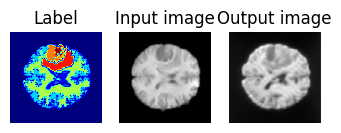

Validation: kld 165.0535; perceptual 0.2635; generator 3.4422;                feature 0.1570; discriminator 1.6425
Epoch 80/100
Train: kld 3206.0751; perceptual 2.0819; generator 11.9550;                    feature 0.0829; discriminator 1.7723


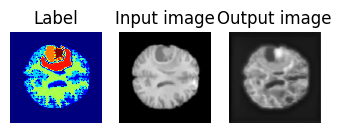

Validation: kld 478.2333; perceptual 0.3472; generator 1.4417;                feature 0.0622; discriminator 3.6480
Epoch 90/100
Train: kld 2999.8330; perceptual 1.6908; generator 13.1768;                    feature 0.0683; discriminator 1.8866


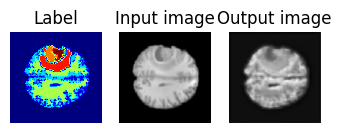

Validation: kld 424.9982; perceptual 0.2865; generator 2.4540;                feature 0.0850; discriminator 3.8034


In [44]:
net = net.to(device)
discriminator = discriminator.to(device)
torch.autograd.set_detect_anomaly(True)
losses = {"kld": [], "perceptual": [], "feature": [], "generator": [], "discriminator": []}
losses_val = {"kld": [], "perceptual": [], "feature": [], "generator": [], "discriminator": []}
for epoch in range(num_epochs):
    if epoch % 10 == 0:
        print("Epoch %d/%d" % (epoch, num_epochs))
    losses_epoch = {"kld": 0, "perceptual": 0, "feature": 0, "generator": 0, "discriminator": 0}
    for step, d in enumerate(train_loader):
        image = d["image"].to(device)
        with torch.no_grad():
            label = one_hot(d["label"], 10).to(device)
        optimizer_G.zero_grad()

        # Losses gen
        out, mu, logvar = net(label, image)
        kld_ = kld_loss(mu, logvar)
        disc_fakes, features_fakes = discriminator(torch.cat([out, label], 1))
        loss_g = adversarial_loss(disc_fakes, target_is_real=True, for_discriminator=False)
        disc_reals, features_reals = discriminator(torch.cat([image, label], 1))
        loss_feat = feature_loss(features_fakes, features_reals, lambda_feat, device)
        loss_perc = perceptual_loss(out, target=image)
        total_loss = loss_g + loss_perc * lambda_perc + kld_ * lambda_kld + loss_feat * lambda_feat
        total_loss.backward(retain_graph=True)
        optimizer_G.step()

        # Store
        losses_epoch["kld"] += kld_.item()
        losses_epoch["perceptual"] += loss_perc.item()
        losses_epoch["generator"] += loss_g.item()
        # Train disc
        out, _, _ = net(label, image)
        disc_fakes, _ = discriminator(torch.cat([out, label], 1))
        loss_d_r = adversarial_loss(disc_reals, target_is_real=True, for_discriminator=True)
        loss_g_f = adversarial_loss(disc_fakes, target_is_real=False, for_discriminator=True)
        optimizer_D.zero_grad()
        loss_d = loss_d_r + loss_g_f
        loss_d.backward()
        optimizer_D.step()

        # Store
        losses_epoch["feature"] = loss_feat.item()
        losses_epoch["discriminator"] = (loss_d_r.item() + loss_g_f.item())/2

    if epoch%10 == 0:
            print("Train: kld %.4f; perceptual %.4f; generator %.4f; \
                   feature %.4f; discriminator %.4f" %(np.mean(losses_epoch["kld"]),  
                                                       np.mean(losses_epoch["perceptual"]),
                                                       np.mean(losses_epoch["generator"]),
                                                       np.mean(losses_epoch["feature"]),
                                                       np.mean(losses_epoch["discriminator"])))


    losses_epoch_val = {"kld": 0, "perceptual": 0, "feature": 0, "generator": 0, "discriminator": 0}
    for step, d in enumerate(val_loader):
        image = d["image"].to(device)
        with torch.no_grad():
            label = one_hot(d["label"], 10).to(device)
            # Losses gen
            out, mu, logvar = net(label, image)
            kld_ = kld_loss(mu, logvar)
            disc_fakes, features_fakes = discriminator(torch.cat([out, label], 1))
            loss_g = adversarial_loss(disc_fakes, target_is_real=True, for_discriminator=False)
            disc_reals, features_reals = discriminator(torch.cat([image, label], 1))
            loss_feat = feature_loss(features_fakes, features_reals, lambda_feat, device)
            loss_perc = perceptual_loss(out, target=image)
            total_loss = loss_adv * loss_g + loss_perc * lambda_perc + kld_ * lambda_kld + loss_feat * lambda_feat
            # Store
            losses_epoch_val["kld"] += kld_.item()
            losses_epoch_val["perceptual"] += loss_perc.item()
            losses_epoch_val["generator"] += loss_g.item()
            # Train disc
            out, _, _ = net(label, image)
            disc_fakes, _ = discriminator(torch.cat([out, label], 1))
            loss_d_r = adversarial_loss(disc_reals, target_is_real=True, for_discriminator=True)
            loss_g_f = adversarial_loss(disc_fakes, target_is_real=False, for_discriminator=True)
            loss_d = loss_adv * (loss_d_r + loss_g_f)

            # Store
            losses_epoch_val["feature"] = loss_feat.item()
            losses_epoch_val["discriminator"] = loss_d_r.item() + loss_g_f.item()


    if epoch % 10 == 0:
        picture_results(label, image, out)
        print("Validation: kld %.4f; perceptual %.4f; generator %.4f; \
               feature %.4f; discriminator %.4f" %(np.mean(losses_epoch_val["kld"]),  
                                                   np.mean(losses_epoch_val["perceptual"]),
                                                   np.mean(losses_epoch_val["generator"]),
                                                   np.mean(losses_epoch_val["feature"]),
                                                   np.mean(losses_epoch_val["discriminator"])))
    for key, val in losses_epoch.items():
        losses[key].append(val / len(train_loader))
    for key, val in losses_epoch_val.items():
        losses_val[key].append(val / len(val_loader))